# Additional collection-wide analysis

In [1]:
import re
import sys
import tarfile
import warnings

from lxml import etree
import numpy as np
import pandas as pd

import genizahdata as gd

# Suppress warnings about messy metadata
warnings.filterwarnings('ignore', category=gd.GenizahDataWarning)

/home/hal/.local/share/virtualenvs/genizah-visualisation-mG8BC0xT/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hal/.local/share/virtualenvs/genizah-visualisation-mG8BC0xT/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


We'll use Vega/Altair for graphical visualisation

In [2]:
import altair as alt

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
bundle = tarfile.open('../medical-data/genizah-tei.tar.lz')

data = pd.DataFrame.from_records(
    (gd.get_data(path, root) for path, root in gd.extract_tar_xml(bundle)),
    index='classmark')
data.head()

,columns,date_end,date_start,height,lines,material,summary,title,width
classmark,,,,,,,,,
MS-ADD-03430,1.0,1028-12-31,1028-01-01,NaN,37.0,vellum,Karaite ketubba for Sarwa bat Ṣedaqa b. Jarīr ...,Legal document: ketubba,NaN
MS-MOSSERI-I-A-00002,1.0,1051-12-31,1051-01-01,NaN,38.0,paper,Karaite betrothal deed for Yamān bat David b. ...,Legal document,NaN
MS-OR-01080-00001-00001,1.0,1899-12-31,0500-01-01,NaN,17.0,paper,Piyyuṭim on parašot Toldot to Qedošim (Genesis...,Piyyuṭ,NaN
MS-OR-01080-00001-00003,1.0,1199-12-31,1000-01-01,NaN,15.0,paper,"Various piyyuṭim, as well as divorce and marri...",Piyyuṭ; liturgy; legal document,NaN
MS-OR-01080-00001-00004,1.0,1899-12-31,0500-01-01,NaN,22.0,paper,Piyyuṭim.,Piyyuṭ,NaN


## Missing metadata

It'd be interesting to get a feel for how much of the collection has descriptive metadata.

Informally we know the collection has very varying levels of metadata coverage.

In [4]:
# Certainly plenty of items with blank fields:
len(data), (pd.isna(data['columns'])).sum()

(23006, 2242)

Items with the most missing fields:

In [5]:
data.reindex(index=(~data.isna()).sum(axis=1).sort_values().index).head()

,columns,date_end,date_start,height,lines,material,summary,title,width
classmark,,,,,,,,,
MS-TS-MISC-00028-00155,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN
MS-OR-01080-J-00190,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN
MS-OR-01080-J-00187,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN
MS-OR-01080-J-00186,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN
MS-OR-01080-J-00185,NaN,1899-12-31,0500-01-01,NaN,NaN,None,,Genizah Fragment,NaN


The title and dates have placeholder default values. The start date 0500-01-01 and end date 1899-12-31 are defaults if a more exact date is not known.

In [6]:
import re

def drop_default_values(genizah_df):
    return genizah_df.replace(to_replace={
        'date_start': {'0500-01-01': None},
        'date_end': {'1899-12-31': None},
        'title': {'Genizah Fragment': None},
        'summary': {re.compile('^\s*$'): None}})

How many items have no (real) metadata?

In [7]:
_blank_items = ((~drop_default_values(data).isna()).sum(axis=1) == 0).sum()
print(f'{_blank_items} items are blank ({_blank_items / data.shape[0]:.1%}) ')

1842 items are blank (8.0%) 


Perhaps breaking down items by the number of blank fields per item is useful:

In [8]:
missing_data = drop_default_values(data).isna()
value_count = len(missing_data.columns)
missing_data['missing_fields'] = missing_data.sum(axis='columns')
missing_data.head()

,columns,date_end,date_start,height,lines,material,summary,title,width,missing_fields
classmark,,,,,,,,,,
MS-ADD-03430,False,False,False,True,False,False,False,False,True,2
MS-MOSSERI-I-A-00002,False,False,False,True,False,False,False,False,True,2
MS-OR-01080-00001-00001,False,True,True,True,False,False,False,False,True,4
MS-OR-01080-00001-00003,False,False,False,True,False,False,False,False,True,2
MS-OR-01080-00001-00004,False,True,True,True,False,False,False,False,True,4


Plot the proportion of fields which are blank over the collection (broken down by number of blank fields per item):

In [9]:
missing_by_type = (missing_data.reset_index()
 .melt(id_vars='classmark', 
       value_vars=('columns date_end date_start height'
                   ' lines material summary title width').split(), var_name='field', value_name='num_missing')
 .groupby('field')
 .sum())
missing_by_type['missing_fields'] = 'All documents'
missing_by_type['group_size'] = missing_data.shape[0]

missing_by_type_breakdown = (missing_data.reset_index()
 .melt(id_vars='classmark missing_fields'.split(), 
       value_vars=('columns date_end date_start height'
                   ' lines material summary title width').split(), var_name='field', value_name='num_missing')
 .groupby(['missing_fields', 'field'])
 .sum().reset_index(level=1))

missing_by_type_breakdown = pd.merge(
    missing_by_type_breakdown, 
    pd.DataFrame(missing_data.groupby('missing_fields').size().rename('group_size')),
    left_on='missing_fields', right_on='missing_fields')

missing = pd.concat([missing_by_type.reset_index(), missing_by_type_breakdown.reset_index()], 
                    ignore_index=True, sort=False)
missing['pct_missing'] = missing['num_missing'] / missing['group_size']


display(missing.head(), missing.tail())

,field,num_missing,missing_fields,group_size,pct_missing
0,columns,2242.0,All documents,23006,0.097453
1,date_end,18551.0,All documents,23006,0.806355
2,date_start,18523.0,All documents,23006,0.805138
3,height,5047.0,All documents,23006,0.219378
4,lines,2242.0,All documents,23006,0.097453


,field,num_missing,missing_fields,group_size,pct_missing
76,lines,1842.0,9,1842,1.0
77,material,1842.0,9,1842,1.0
78,summary,1842.0,9,1842,1.0
79,title,1842.0,9,1842,1.0
80,width,1842.0,9,1842,1.0


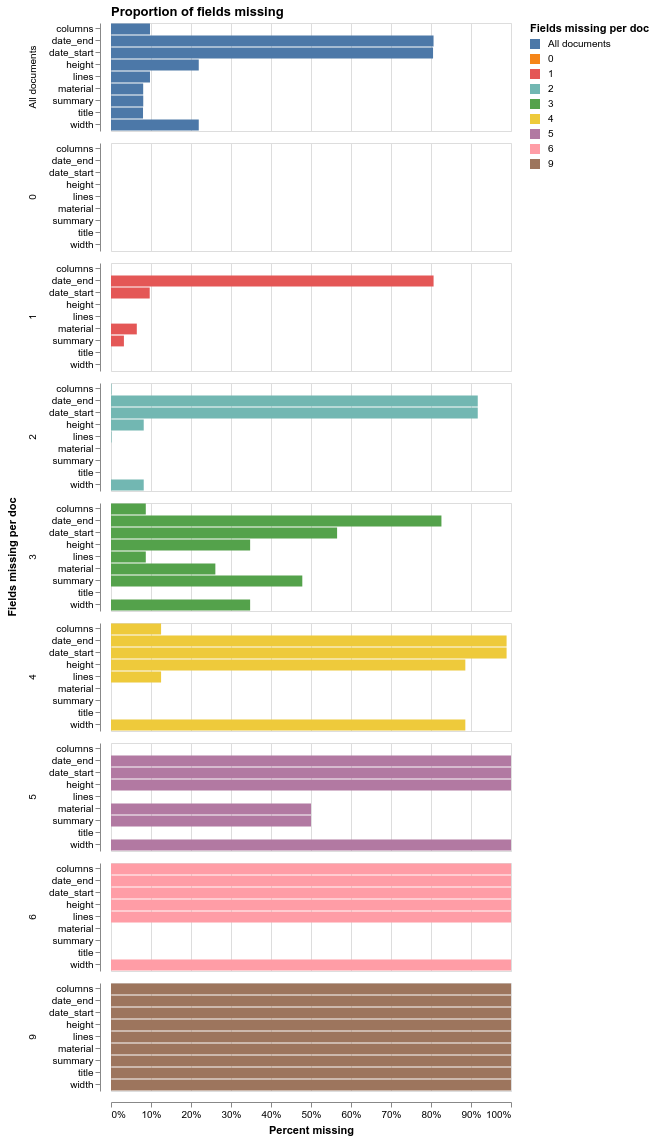

In [10]:
(alt.Chart(missing.rename(columns=dict(missing_fields='Fields missing per doc',
                                       pct_missing='Percent missing',
                                       group_size='Group size')), title='Proportion of fields missing')
    .mark_bar(orient='vertical')
    .encode(alt.Y('field:N', title=None, scale=alt.Scale(rangeStep=12)),
            alt.X('Percent missing:Q', axis=alt.Axis(format='%')),
            row='Fields missing per doc:N',
            color=alt.Color('Fields missing per doc:N'),
            tooltip=[alt.Tooltip('Percent missing', format='.1%'),
                     alt.Tooltip('Group size')]))

A problem with the above is that the groups vary in size a lot, and the difference in size is not reflected. E.g. group 4 and 5 look similar, but 5 contains only 2 items.

In [11]:
missing_by_var = missing_data.melt(id_vars='missing_fields', var_name='field').groupby(['missing_fields', 'field'])


missing = pd.concat([missing_by_var.sum().rename(columns=dict(value='docs_without_field')),
                     missing_by_var.count().rename(columns=dict(value='docs_without_n_fields'))], axis=1)

# The proportion of all missing values which are type X
missing['var_weight'] = (missing[['docs_without_field']] / 
                         missing[['docs_without_field']].sum(level=0))
# The group with 0 missing values have NaN weight due division by zero - we'll use
# zero weighting for all value types in this case as none are missing.
missing.loc[0, 'var_weight'] = 0

# I the breakdown of types missing to match the quantity of documents in
# each type, so that the viewer sees the parallel between values missing and
# 

# We want to present the fraction of values missing by type (in groups of
# documents with N values missing) to be proportional to the number of
# affected documents. Partly so that the user sees the parallel between the
# number-of-documents-with-N-values-missing graph and the missing values
# breakdown, but also so that bands large bands really indicate large numbers
# of missing values.
missing['var_size'] = missing['docs_without_n_fields'] * missing['var_weight']

missing.loc[2]

,docs_without_field,docs_without_n_fields,var_weight,var_size
field,,,,
columns,21.0,15881,0.000661,10.5
date_end,14561.0,15881,0.458441,7280.5
date_start,14561.0,15881,0.458441,7280.5
height,1299.0,15881,0.040898,649.5
lines,21.0,15881,0.000661,10.5
material,0.0,15881,0.000000,0.0
summary,0.0,15881,0.000000,0.0
title,0.0,15881,0.000000,0.0
width,1299.0,15881,0.040898,649.5


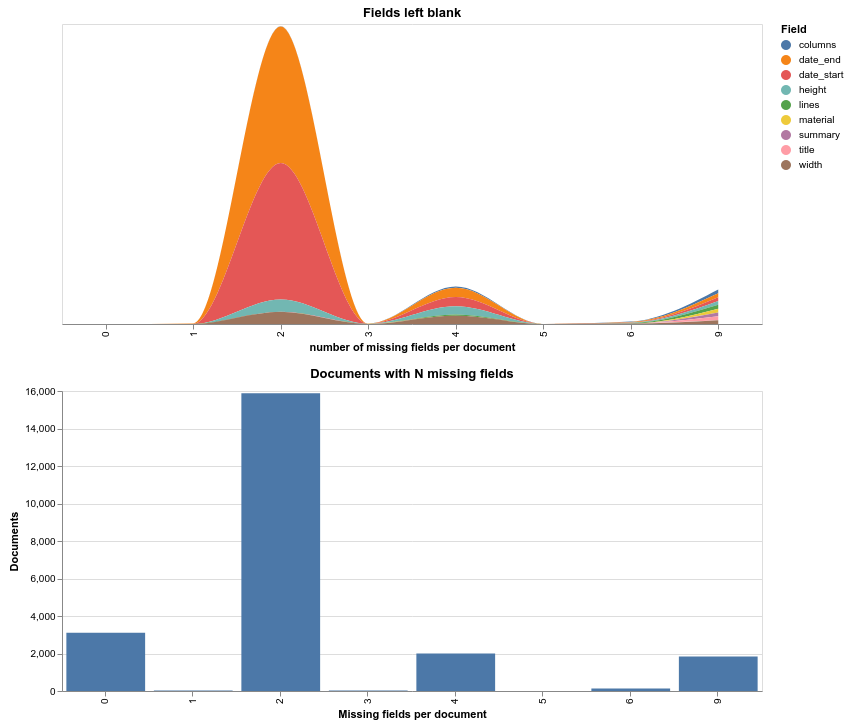

In [12]:
from altair import datum


chart = alt.Chart(missing.reset_index().rename(columns=dict(field='Field')), width=700)
upper = (chart.properties(title='Fields left blank')
    .mark_area(interpolate='monotone')
    .encode(x=alt.X('missing_fields:O',
                    title='number of missing fields per document'),
            y=alt.Y(aggregate='sum', field='var_size', type='quantitative', #stack='normalize', 
                    axis=None),
            color='Field'
    )
)

lower = (chart.properties(title='Documents with N missing fields')
    .mark_bar(interpolate='monotone')
    .encode(x=alt.X('missing_fields:O', title='Missing fields per document'),
            y=alt.Y(field='Documents', type='quantitative')
    )
    .transform_aggregate(Documents='max(docs_without_n_fields)', groupby=['missing_fields']))

upper & lower

We can see that dates make up the bulk of missing data, followed by height and width of items.

# Item relationships

In [04-data-visualisation](04-data-visualisation.ipynb) we tried to find associations between items by finding co-occuring terms in their descriptions. Another approach is to use use clustering methods to group items. We'll use k-means, applied to the item descriptions in a bag-of-words representation - each document occupies a point in n-dimentional space, where n is the number of words in the entire corpus of descriptions.

See: http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

In [13]:
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [14]:
descriptions = drop_default_values(data[['summary']])['summary'].dropna()

display(descriptions.head(), descriptions.size)

classmark
MS-ADD-03430               Karaite ketubba for Sarwa bat Ṣedaqa b. Jarīr ...
MS-MOSSERI-I-A-00002       Karaite betrothal deed for Yamān bat David b. ...
MS-OR-01080-00001-00001    Piyyuṭim on parašot Toldot to Qedošim (Genesis...
MS-OR-01080-00001-00003    Various piyyuṭim, as well as divorce and marri...
MS-OR-01080-00001-00004                                            Piyyuṭim.
Name: summary, dtype: object

21151

Convert descriptions to word vectors...

In [15]:
vectoriser = CountVectorizer()

corpus = vectoriser.fit_transform(list(descriptions))
corpus

<21151x17967 sparse matrix of type '<class 'numpy.int64'>'
	with 302461 stored elements in Compressed Sparse Row format>

We apply TF IDF to boost significant terms, and supress less significant terms.

In [16]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(corpus)
tfidf

<21151x17967 sparse matrix of type '<class 'numpy.float64'>'
	with 302461 stored elements in Compressed Sparse Row format>

We can see the corpus-wide (inverse document frequency) weights found for the terms:

In [17]:
from IPython.core.display import Markdown

_tokens = pd.DataFrame.from_records(list(vectoriser.vocabulary_.items()), 
                          columns=['token', 'index'], index='index').sort_index()
_weights = pd.DataFrame({'idf_weight': transformer.idf_})

_global_term_weights = pd.concat([_tokens, _weights], axis=1).sort_values('idf_weight')

display(Markdown('### Less significant terms'), _global_term_weights.head(10),
        Markdown('### More significant terms'), _global_term_weights.tail(10))

### Less significant terms

,token,idf_weight
index,,
12768,the,1.847755
9242,of,1.867708
2073,and,1.912963
6588,in,2.469462
5578,for,2.496119
12893,to,2.538147
9291,on,2.626219
13645,with,2.670453
5685,from,2.701326


### More significant terms

,token,idf_weight
index,,
1918,aleppians,10.266343
9711,pericopes,10.266343
9713,periodicity,10.266343
1916,aleman,10.266343
9717,perishing,10.266343
9718,permanent,10.266343
9719,permissibility,10.266343
1915,alefs,10.266343
1913,aldabi,10.266343


We can use Latent Semantic Analysis to reduce the dimentionality of our document-term matrix. This has benefits such as:

* speeding up our k-means clustering
* allowing synonymous terms to match without being explicitly included in documents

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# 100 components is a recommended value for LSA
svd = TruncatedSVD(100)
# By normalising our vectors (to length 1) our k-means clustering 
# effectively works on angular distance, rather than ecludian distance, 
# which works better for comparing texts.
normaliser = Normalizer(copy=False)
lsa = make_pipeline(svd, normaliser)

In [19]:
reduced = lsa.fit_transform(tfidf)
display(reduced, reduced.shape)

array([[ 0.34132099, -0.17661946,  0.0714117 , ...,  0.00762035,
        -0.04196961,  0.04260694],
       [ 0.53632734, -0.30500677,  0.12235362, ...,  0.05027366,
         0.04465794,  0.04927617],
       [ 0.30585197, -0.22921633,  0.09953518, ...,  0.02536106,
        -0.0535793 ,  0.03507993],
       ...,
       [ 0.6354089 ,  0.34413662, -0.36990926, ...,  0.04789969,
         0.04717045, -0.0174894 ],
       [ 0.56181615,  0.38807167, -0.12684374, ..., -0.00955765,
        -0.01191528, -0.00665006],
       [ 0.59978915,  0.30091782, -0.3361102 , ...,  0.02428697,
         0.02454913, -0.01553562]])

(21151, 100)

We use k-means to group our vector document representations according to similarity. Similar documents will be represented by vectors which point in similar directions, compared to dissimilar documents.

In [20]:
from sklearn.cluster import KMeans

# determined by manual experimentation, comparing silhouette values
n_clusters = 80

km = KMeans(n_clusters=n_clusters)
km.fit(reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=80, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Find the most prominent terms in each of our clusters to get an idea of what each cluster represents:

Clusters are in our reduced LSA space...

In [21]:
km.cluster_centers_.shape

(80, 100)

...but we want the original terms, so we need to reverse the reduction:

In [22]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
display(original_space_centroids, original_space_centroids.shape)

array([[ 4.31504072e-04,  1.19194541e-04,  7.00053615e-04, ...,
         2.59881277e-04,  6.83494075e-05,  8.98327350e-04],
       [ 1.92241312e-04,  1.11219651e-04, -1.53599803e-04, ...,
         3.48208482e-04,  1.95973155e-04,  5.47015875e-04],
       [ 1.47317982e-05, -2.40940295e-05, -1.35441688e-05, ...,
         8.52529086e-06,  4.61250072e-06,  2.31692097e-05],
       ...,
       [ 1.87945049e-04,  4.37268130e-07, -3.47954145e-05, ...,
        -1.07481921e-04, -9.52457461e-06,  3.39985897e-05],
       [ 1.54357879e-03, -8.45689419e-06, -1.28303393e-05, ...,
         4.47721117e-05,  1.45028753e-05, -6.65450727e-05],
       [ 1.11305562e-04, -2.36901984e-06,  1.09490912e-05, ...,
        -5.26580411e-05, -1.53859062e-05,  1.05010214e-04]])

(80, 17967)

`argsort` gives us the *indexes* which (if dereferenced) would give
a sorted list. The indexes in the term vector are of course the same
as in the weighted version, so by argsorting on the weights, we 
obtain the indexes of terms in order of prominence/contribution to a
specific cluster.

In [23]:
ordered_centroids = original_space_centroids.argsort()[:, ::-1]
ordered_centroids

array([[12768,  9242,  3309, ...,   372, 14129,  5432],
       [12893, 12768,  6342, ...,  5792, 11640,  5020],
       [12991,  6603,  6240, ..., 11828,  7098, 10608],
       ...,
       [ 8174, 13645, 13672, ..., 10791, 10608,  3173],
       [ 9587,  9242,  7551, ...,  2874,  6078,  2782],
       [11487, 11828,  5792, ...,  7563,  6603, 12991]])

In [24]:
terms = vectoriser.get_feature_names()

top_cluster_terms = pd.DataFrame({
    'top_terms': [[terms[j] for j in ordered_centroids[i, :20]] 
                            for i in range(n_clusters)]})
top_cluster_terms.index.name = 'label'
top_cluster_terms.head()

,top_terms
label,
0,"[the, of, ce, legal, document, dated, and, abū..."
1,"[to, the, his, and, letter, in, from, of, he, ..."
2,"[translation, incipits, hebrew, with, saʿadya,..."
3,"[piyyuṭ, arabic, in, recto, verso, letter, par..."
4,"[de, zimra, pesuqe, morning, benedictions, ser..."


## Cluster quality

K-means assigns items to one of *n* clusters, so selecting the number of clusters is important. I don't really have any sense of how many would work well for the Genizah data set, so I experiment with different values, combined results using the Silhouette Coefficient for items. 

In [25]:
from sklearn.metrics import silhouette_score, silhouette_samples

The `silhouette_score` gives us the average score over all items, which gives some indication of the separation of items. Values range from -1 to 1, with values nearer to 1 being further away from neighboring clusters, and values near 0 being close to the boundary between the item's cluster and the nearest other cluster.

In [26]:
silhouette_score(reduced, km.labels_)
# Experimentation with various cluster numbers:
# 32: 0.15
# 38: 0.17
# 47: 0.18 
# 50: 0.834
# 55: 0.188
# 64: 0.19
# 128: 0.2
# 256: 0.20
# 512: 0.21

0.19883807462737527

In [27]:
ss = silhouette_samples(reduced, km.labels_)
ss.shape

(21151,)

In [28]:
cluster_silhouettes = pd.DataFrame({'silhouette': ss, 'label': km.labels_})
display(cluster_silhouettes.head())
cluster_silhouettes.shape

,silhouette,label
0,-0.026056,52
1,0.100464,49
2,-0.053084,62
3,0.084830,33
4,0.080234,57


(21151, 2)

Analyse distribution of each cluster's silhouette coefficient values with histograms:

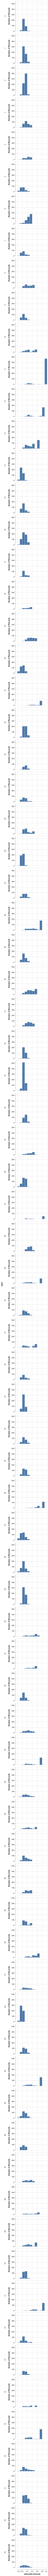

In [29]:
(alt.Chart(cluster_silhouettes)
    .mark_bar()
    .encode(x=alt.X('silhouette:Q', 
                    bin=alt.Bin(maxbins=20), 
                    axis=alt.Axis(grid=True)),
            y=alt.Y('count()'))
    .properties(width=180, height=180)
    .facet('label:N'))

Alternative view of silhouette coefficient distribution by cluster:

,label,Aggregate,value
0,0,mean,0.069880
1,1,mean,0.086366
2,2,mean,0.112254
3,3,mean,0.176302
4,4,mean,0.218239


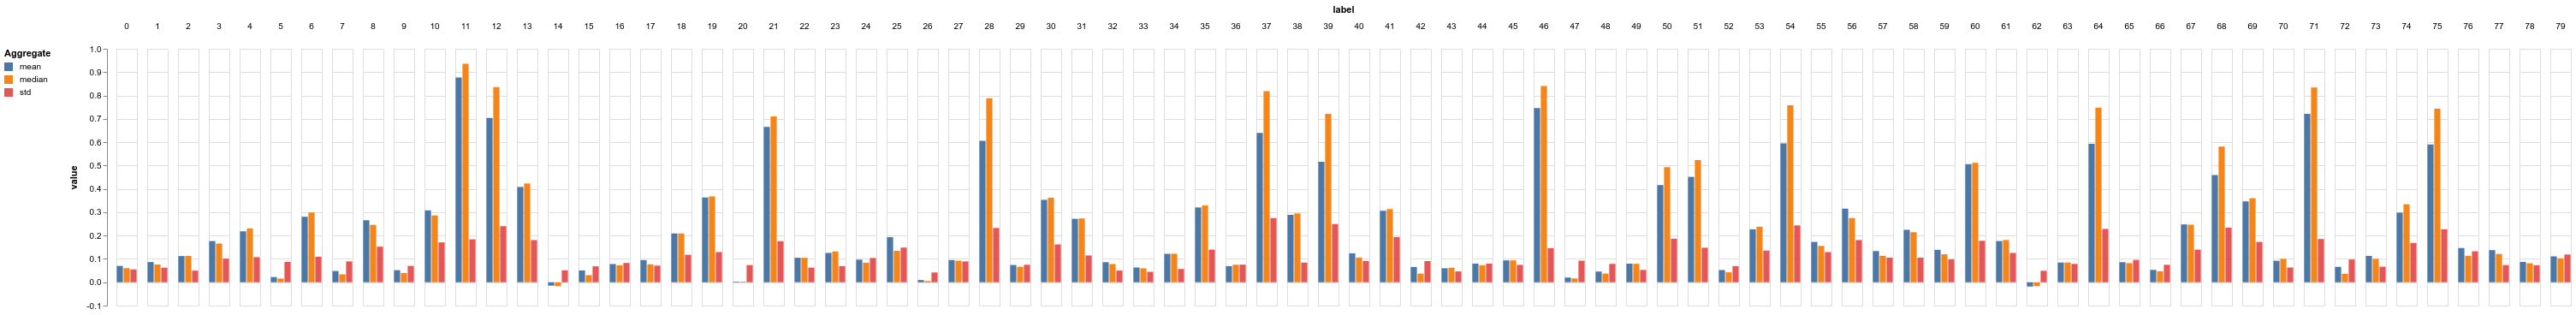

In [30]:
g = cluster_silhouettes.groupby('label')

sil_group_stats = pd.DataFrame({
    'mean': g['silhouette'].mean(),
    'median': g['silhouette'].median(),
    'std': g['silhouette'].std()
}).reset_index().melt(var_name='Aggregate', id_vars='label')

display(sil_group_stats.head())

(alt.Chart(sil_group_stats)
    .mark_bar()
    .encode(x=alt.X('Aggregate:N', title=None, scale=alt.Scale(rangeStep=8), axis=None),
            y='value:Q',
            column='label:N',
            color=alt.Color('Aggregate:N', legend=alt.Legend(orient='left'))))


In [31]:
clusters = pd.DataFrame({'silhouette_mean': cluster_silhouettes.groupby('label').mean()['silhouette'], 
                        'top_terms': top_cluster_terms['top_terms']})
display(clusters.head())
clusters.shape


,silhouette_mean,top_terms
label,,
0,0.069880,"[the, of, ce, legal, document, dated, and, abū..."
1,0.086366,"[to, the, his, and, letter, in, from, of, he, ..."
2,0.112254,"[translation, incipits, hebrew, with, saʿadya,..."
3,0.176302,"[piyyuṭ, arabic, in, recto, verso, letter, par..."
4,0.218239,"[de, zimra, pesuqe, morning, benedictions, ser..."


(80, 2)

In [32]:
reasonable_groups = cluster_silhouettes.groupby('label').mean().query('silhouette >= 0.2')
reasonable_groups

,silhouette
label,
4,0.218239
6,0.280552
8,0.265566
10,0.307891
11,0.877571
12,0.704141
13,0.408115
18,0.209001
19,0.363104


In [33]:
_labeled_descriptions = (pd.concat([pd.DataFrame(descriptions).reset_index(), 
           pd.Series(km.labels_, name='label')], axis=1))
cluster_members = _labeled_descriptions.groupby('label')
cluster_members.get_group(0).head()

,classmark,summary,label
149,MS-OR-01081-00002-00025,"Report about the death of Saʿdiyya bat Yūsuf, ...",0
288,MS-TS-AR-00018-00001-00133,"Legal document, mentioning Abū Saʿīd, Ibn al-ʿ...",0
291,MS-TS-AR-00018-00001-00136,F. 1: various (drafts of) legal documents in t...,0
531,MS-TS-AR-00030-00030,"F. 2v: legal document through which Ḥasan, kno...",0
599,MS-TS-AR-00043-00054,Recto: part of a medical work on lice and delo...,0


In [34]:
from html import escape as escape

def esc(x):
    return escape(str(x))

In [38]:
from IPython.core.display import HTML

rendered_clusters = []

def render_member(member):
    classmark, summary = member[['classmark', 'summary']]
    
    return f'<tr><td><a href="https://cudl.lib.cam.ac.uk/view/{esc(classmark)}">{esc(classmark)}</a></td><td>{escape(summary)}</td></tr>'

selected_clusters = (clusters
                     .sort_values('silhouette_mean', ascending=False)
                     .query('silhouette_mean >= 0.2'))

for cluster, (silhouette, terms) in selected_clusters.iterrows():
    members = cluster_members.get_group(cluster)
    rendered_members = '\n'.join(render_member(member) 
                                 for _, member in members.iterrows())
    cluster_size = len(members)
    
    rendered_terms = ''.join(f'<code class="term">{esc(term)}</code> ' for term in terms)
    
    rendered_clusters.append(f'''
<h2>Cluster <strong>#{esc(cluster)}</strong> <small>(size: {cluster_size}, mean silhouette score: {silhouette:.2f})</small></h2>

<h3>Top terms</h3>

<div class="terms">
{rendered_terms}
</div>

<h3>Members</h3>

<div class="members-pane">
<table class="cluster-members">
<tr><th>Classmark</th><th>Description</th></tr>
{rendered_members}
</table>
</div>
    ''')

HTML('''
<style>
.terms .term {
  padding-left: 1em;
  padding-right: 1em;
}

.members-pane {
  overflow-y: auto;
  max-height: 400px;
}

table.cluster-members td, table.cluster-members th {
    overflow: hidden; 
    white-space: nowrap;
    text-align: left;
}
</style>
''' + f'''
<h1>Clusters <small>({len(selected_clusters)}/{len(clusters)} shown)</small></h1>

{''.join(rendered_clusters)}
''')

Classmark,Description
MS-LG-TALMUD-00002-00029,Commentary on the Passover Haggada.
MS-MOSSERI-I-00033-00002,"Passover Haggada, with a few words from the first introduction to the midraš."
MS-MOSSERI-I-00095,"Passover Haggada, the opening and main body of the midraš."
MS-MOSSERI-I-00096-00001,"Passover Haggada, the opening and main body of the midraš."
MS-MOSSERI-I-00100-00001,"Passover Haggada, the midraš."
MS-OR-01080-00002-00044,Passover Haggada.
MS-OR-01080-00010-00020,Passover Haggada. According to the Palestinian rite.
MS-OR-01080-00013-00013,Passover Haggada.
MS-OR-01080-00013-00053,Passover Haggada.
MS-OR-01080-00015-00040,Passover Haggada.
